In [1]:
import pandas as pd 

df = pd.read_csv('/home/gwm-279/Documents/Data_science_end_to_end/data/processed_data.csv',index_col=False)
df.head(2)

,property_type,township,bedrooms,property_size,price
0,Penthouse,Mayangone,3,6000,4500
1,Condo,Kamayut,3,2000,2300


Removing outliers in price as real estate data usually has crazy prices.

In [2]:
df = df[df["price"] < df["price"].quantile(0.95)]
df = df[df["price"] > df["price"].quantile(0.05)]

Drop target column

In [3]:
import numpy as np 

y = df['price']
y = np.log1p(df["price"])
x = df.drop('price',axis=1)

Split numerical and categorical columns

In [4]:
numerical = x.select_dtypes(include='int64').columns.to_list()
categorical = x.select_dtypes(include='object').columns.to_list()

print(f'Numerical columns : {numerical}')
print(f'Categorical columns : {categorical}')


Numerical columns : ['bedrooms', 'property_size']
Categorical columns : ['property_type', 'township']


Preprocessing according to column type

In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
                transformers=[
                    ('numerical_transforms',StandardScaler(),numerical),
                    ('categorical_transforms',OneHotEncoder(),categorical)
                ]
            )

x_fitted = preprocessor.fit_transform(x) 


In [6]:
x_fitted.shape

(738, 31)

Train-Test split

In [7]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x_fitted,y,random_state=23,test_size=0.2)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(590, 31) (590,)
(148, 31) (148,)


Model training and evaluation

In [11]:
import numpy as np 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import median_absolute_error

def evaluate(test, pred):
    r2 = round(r2_score(test, pred), 2)
    mae = round(mean_absolute_error(test, pred), 2)
    medae = round(median_absolute_error(test, pred), 2)
    rmse = round(np.sqrt(mean_squared_error(test, pred)), 2)
    return r2, mae, medae, rmse


models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "AdaBoost Regressor": AdaBoostRegressor()
}
results = []
for model_name,model in models.items():
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    r2,mae,medae,rmse = evaluate(y_test,y_pred)
    results.append({'model_name':model_name,
                    'r2' : r2,
                    'mae':mae,
                    'medae':medae,
                    'rmse':rmse})

    print(model_name)
    print(f'r2 score : {r2}, MAE : {mae}, MEDAE : {medae}, RMSE : {rmse}')

Linear Regression
r2 score : 0.49, MAE : 0.31, MEDAE : 0.24, RMSE : 0.39
Lasso
r2 score : -0.0, MAE : 0.45, MEDAE : 0.43, RMSE : 0.54
Ridge
r2 score : 0.49, MAE : 0.31, MEDAE : 0.25, RMSE : 0.39
K-Neighbors Regressor
r2 score : 0.5, MAE : 0.28, MEDAE : 0.22, RMSE : 0.38
Decision Tree
r2 score : 0.33, MAE : 0.32, MEDAE : 0.23, RMSE : 0.44
Random Forest Regressor
r2 score : 0.55, MAE : 0.27, MEDAE : 0.23, RMSE : 0.36
AdaBoost Regressor
r2 score : 0.53, MAE : 0.3, MEDAE : 0.26, RMSE : 0.37


The Random Forest model is the best result, followed by AdaBoost (good), KNN (okay), Ridge/Linear (moderate), Decision Tree (weak), and Lasso performing the worst.

In [12]:
pd.DataFrame(results) 

,model_name,r2,mae,medae,rmse
0,Linear Regression,0.49,0.31,0.24,0.39
1,Lasso,-0.00,0.45,0.43,0.54
2,Ridge,0.49,0.31,0.25,0.39
3,K-Neighbors Regressor,0.50,0.28,0.22,0.38
4,Decision Tree,0.33,0.32,0.23,0.44
5,Random Forest Regressor,0.55,0.27,0.23,0.36
6,AdaBoost Regressor,0.53,0.30,0.26,0.37


In [17]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=23)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, scoring='r2', verbose=2)

grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(x_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R2: {r2:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END m

In [19]:

results = pd.DataFrame({
    'Actual': np.expm1(y_test),
    'Predicted': np.expm1(y_pred)
})
results.head(10)

,Actual,Predicted
28,1200.0,1643.276467
242,4000.0,4092.292297
22,1600.0,2643.830175
385,1300.0,1360.480926
24,1800.0,2503.406911
159,4000.0,3732.320320
757,2100.0,1635.294328
148,3000.0,2617.029034
635,4200.0,3337.148992
132,3500.0,2666.463862


Results Visualization

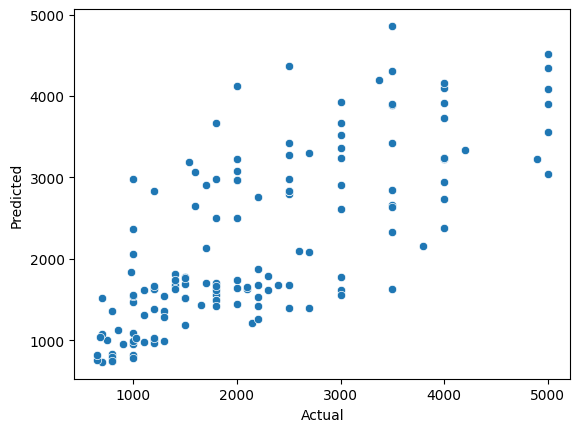

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=results, x='Actual', y='Predicted')
plt.show()


Files saved for model deployment

In [ ]:
import pickle
import os 

os.makedirs('artifacts_v2',exist_ok=True)

with open('artifacts_v2/ridge_model.pkl','wb') as f:
    pickle.dump(ridge_model,f)      
with open('artifacts_v2/linear_model.pkl','wb') as f:
    pickle.dump(linear_model,f)                     
with open('artifacts_v2/preprocessor.pkl','wb') as f:
    pickle.dump(preprocessor,f)
print('All files saved in artifacts_v2')

All files saved in artifacts
